<a href="https://colab.research.google.com/github/cedricfoucault/scarletbutterfly/blob/master/scarletbutterfly_decoding_steinmetz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

In [1]:
#@title Data retrieval
import os, requests
import matplotlib.pyplot as plt
fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [2]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

n_sessions = len(alldat)
print("n_sessions", n_sessions)

n_sessions 39


In [3]:
print(alldat[0].keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [4]:
#@title Filter Trial Data
import copy
filtered_data = copy.deepcopy(alldat)

bin_size = alldat[0]['bin_size']
stim_onset = alldat[0]['stim_onset']
for i in range(len(alldat)):
  assert bin_size == alldat[i]['bin_size'], "inconsistent bin size"
  assert stim_onset == alldat[i]['stim_onset'], "inconsistent stim onset"

# Filter only the keys we are going to use
# used_keys = ['spks', 'pupil', 'lfp', 'response', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'mouse_name']
used_keys = ['spks', 'pupil', 'response', 'contrast_right', 'contrast_left', 'brain_area', 'mouse_name']
for i_session in range(n_sessions):
  filtered_data[i_session] = { key: filtered_data[i_session][key] for key in used_keys }


# # Eliminate trials where contrast is > 0 and equal on both sides
array_keys = ['spks', 'pupil','lfp', 'response', 'contrast_right', 'contrast_left']



for i_session in range(n_sessions):
  session_data = filtered_data[i_session]
  equal_contrast = session_data['contrast_right'] == session_data['contrast_left']
  positive_contrast_right = session_data['contrast_right'] > 0
  should_filter = equal_contrast & positive_contrast_right

  session_data['spks'] = session_data['spks'][:,~should_filter,:]
  session_data['pupil'] = session_data['pupil'][:,~should_filter,:]
  # session_data['lfp'] = session_data['lfp'][:,~should_filter,:]

  session_data['response'] = session_data['response'][~should_filter]
  session_data['contrast_right'] = session_data['contrast_right'][~should_filter]
  session_data['contrast_left'] = session_data['contrast_left'][~should_filter]

  # for key, value in session_data.items():
  #   if key in array_keys:
  #     print("key", key)
  #     print("array.shape", value.shape)
  # new_session_data = { key: array[~should_filter] for key, array in session_data.items() }
  # filtered_data[i_session] = new_session_data
  # print("session:", i_session)
  # print("original data, contrast_right:", session_data['contrast_right'])
  # print("filtered data, contrast_right:", new_session_data['contrast_right'])






In [5]:
#Extracting brain areas:
brain_areas = set()

for i in range(n_sessions):
  brain_areas.update(filtered_data[i]['brain_area'])


#Let's focus on subcortical brain areas as they appear to experience a spike 
#Basal ganglia, midbrain
basal_ganglia = ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"]
midbrain = ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"]

count_dict = {area:0 for area in brain_areas}

for i in range(n_sessions):
  for area in set(filtered_data[i]['brain_area']):
      count_dict[area] += 1

print(count_dict)
areas = list(count_dict.keys())
count_sessions_per_areas = np.array(list(count_dict.values()))
sorted_indices = np.argsort(count_sessions_per_areas)
areas = [ areas[i] for i in sorted_indices ]
count_sessions_per_areas = count_sessions_per_areas[sorted_indices]
y_bars = np.arange(len(areas))
# fig = plt.figure(figsize=(5., len(y_bars) / 4))
# ax = fig.gca()
# ax.barh(y_bars, count_sessions_per_areas)
# ax.set_yticks(y_bars)
# ax.set_yticklabels(areas)
# plt.show()

{'VAL': 1, 'EPd': 1, 'LP': 11, 'RT': 2, 'ORBm': 1, 'PO': 5, 'DG': 16, 'PAG': 3, 'MOp': 3, 'SCs': 4, 'BLA': 2, 'PL': 10, 'CL': 1, 'IC': 1, 'LSc': 1, 'SUB': 9, 'VISpm': 4, 'POST': 4, 'SI': 1, 'VISa': 5, 'LSr': 4, 'CA2': 1, 'PT': 1, 'VPL': 4, 'SSs': 1, 'EP': 1, 'MEA': 1, 'APN': 2, 'POL': 3, 'MS': 1, 'SNr': 4, 'RN': 1, 'TT': 4, 'SSp': 5, 'PIR': 1, 'ILA': 3, 'BMA': 1, 'SCig': 4, 'SCm': 7, 'CA3': 10, 'MD': 3, 'CA1': 21, 'SPF': 2, 'OLF': 3, 'MG': 2, 'VISl': 3, 'CP': 5, 'VISam': 11, 'OT': 1, 'ACB': 3, 'DP': 1, 'ZI': 4, 'CA': 1, 'MOs': 18, 'ACA': 11, 'TH': 8, 'NB': 1, 'LGd': 10, 'GPe': 3, 'LS': 3, 'SCsg': 6, 'RSP': 9, 'root': 34, 'VISrl': 2, 'LH': 2, 'COA': 1, 'AUD': 1, 'MRN': 11, 'LD': 6, 'VISp': 12, 'ORB': 5, 'MB': 6, 'VPM': 4}


In [6]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

In [7]:
# Histograms of num. of neurons by brain area for each session
# for i in range(n_sessions):
#   plt.hist(filtered_data[i]['brain_area'])
#   plt.show()

In [32]:
# Calculate number of trials per session
n_trials_session = np.zeros(n_sessions)
for i in range(n_sessions):
  n_trials_session[i] = len(filtered_data[i]['response'])

In [ ]:
#@title Histogram of number of trials throughout the sessions
# Histogram of number of trials throughout the sessions
plt.hist(n_trials_session)
print(n_trials_session.mean())

In [ ]:
# Select one session
i_session_max_trials = np.argmax(n_trials_session)
print(i_session_max_trials, n_trials_session[i_session_max_trials])

We'll focus on the session i_session_max_trials, which has the most trials and analyze the activity in the brain areas recorded during this session to try to predict the mouse's response during the trials.

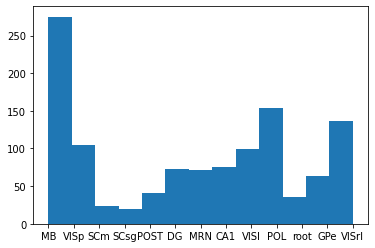

275

In [9]:
#@title Histogram of num of neurons per brain area for the selected session 
plt.hist(filtered_data[i_session_max_trials]['brain_area'],bins=13)
plt.show()
np.count_nonzero(filtered_data[i_session_max_trials]['brain_area']=='MB')

## Helper functions for retrieving data

In [62]:
def get_outcomes_correct_with_session(session_data):
  response = session_data['response'] # right - nogo - left (-1, 0, 1)
  vis_right = session_data['contrast_right'] # 0 - low - high
  vis_left = session_data['contrast_left'] # 0 - low - high
  correct_response = np.sign(vis_left-vis_right) 
  is_correct = response == correct_response
  outcomes_correct = is_correct.astype(int)
  return outcomes_correct

In [64]:
#@title Retrieve correct (1) or incorrect (0) outcome
i_focus = i_session_max_trials
outcomes_correct = get_outcomes_correct_with_session(filtered_data[i_focus])
print(outcomes_correct.mean())

0.6376811594202898


In [15]:
spikes_focus.shape # neur*tri*tim

(275, 414, 250)

In [54]:
def get_neurons_spikes_with_session_area_window(session_data, brain_area, window):
  is_brain_area = session_data['brain_area'] == brain_area
  return session_data['spks'][is_brain_area, :, window]

In [42]:
focus_brain_area='MB'
spikes_focus = get_neurons_spikes_with_session_area_window(filtered_data_focus, focus_brain_area, slice(0, 250, 1))


(1172, 414, 250)


## Helper functions for decoding

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [52]:
def compute_single_neuron_decoding_accuracies(spikes_per_neuron, outcomes, penalty='none'):
  n_neurons = spikes_per_neuron.shape[0]
  n_trials = spikes_per_neuron.shape[1]
  # average over time
  spikes_per_neuron_time_avg = spikes_per_neuron.mean(axis=2)
  decoding_accuracies = np.empty(n_neurons)
  decoding_accuracies_chance = np.empty(n_neurons)
  for i_neuron in range(n_neurons):
    X = spikes_per_neuron_time_avg[i_neuron, :][:, None]
    decoding_accuracies[i_neuron] = cross_val_score(LogisticRegression(penalty=penalty), X, outcomes, cv=8, n_jobs=-1).mean()
    # shuffle trials to get chance level
    X = X.copy()
    np.random.shuffle(X)
    decoding_accuracies_chance[i_neuron] = cross_val_score(LogisticRegression(penalty=penalty), X, outcomes, cv=8, n_jobs=-1).mean() # k=8 crossvalidation
  return decoding_accuracies, decoding_accuracies_chance

## Decode from each individual neuron on each possible brain area and sessions

session 0
decoding on brain_area ACA
decoding on brain_area LS
decoding on brain_area CA3
decoding on brain_area DG
decoding on brain_area root
decoding on brain_area SUB
decoding on brain_area VISp
decoding on brain_area MOs
found!
max diff:  0.04500000000000004


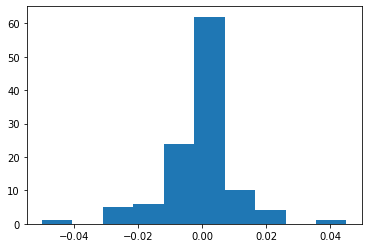

session 1
decoding on brain_area CA1
decoding on brain_area root
decoding on brain_area VISl
decoding on brain_area VISpm
found!
max diff:  0.04371921182266014


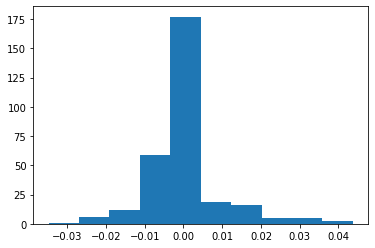

decoding on brain_area POST
session 2
decoding on brain_area LP
decoding on brain_area NB
decoding on brain_area CA1
decoding on brain_area DG
decoding on brain_area SPF
decoding on brain_area root
decoding on brain_area MG
decoding on brain_area VISam
decoding on brain_area MRN
decoding on brain_area POST
decoding on brain_area VISp
session 3
decoding on brain_area ACA
decoding on brain_area TH
decoding on brain_area LGd
decoding on brain_area DG
decoding on brain_area CA1
decoding on brain_area SUB
decoding on brain_area VISp
decoding on brain_area VISa
decoding on brain_area LSr
decoding on brain_area MOs
decoding on brain_area VPL
session 4
decoding on brain_area ACA
found!
max diff:  0.0401785714285714


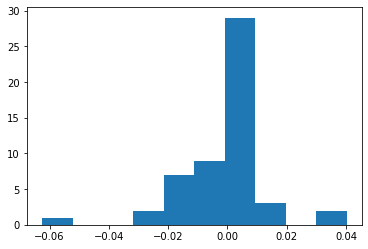

decoding on brain_area CA1
decoding on brain_area DG
decoding on brain_area root
decoding on brain_area OLF
decoding on brain_area PL
decoding on brain_area SUB
decoding on brain_area VISa
decoding on brain_area ORB
decoding on brain_area MOs
found!
max diff:  0.04341133004926112


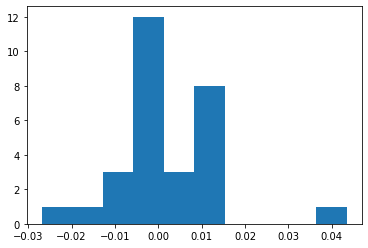

session 5
decoding on brain_area TH
decoding on brain_area CA1
decoding on brain_area root
decoding on brain_area AUD
decoding on brain_area SSp
session 6
decoding on brain_area EPd
decoding on brain_area CA3
decoding on brain_area root
decoding on brain_area CP
decoding on brain_area SSp
decoding on brain_area LD
decoding on brain_area PIR
decoding on brain_area VPL
session 7
decoding on brain_area ILA
found!
max diff:  0.043247126436781635


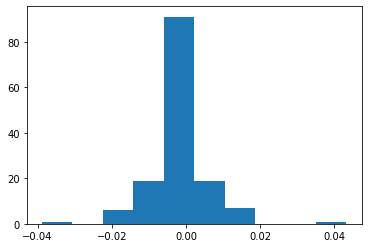

decoding on brain_area LP
decoding on brain_area CA3
decoding on brain_area PO
decoding on brain_area CA1
decoding on brain_area DG
decoding on brain_area root
decoding on brain_area PL
found!
max diff:  0.09439655172413786


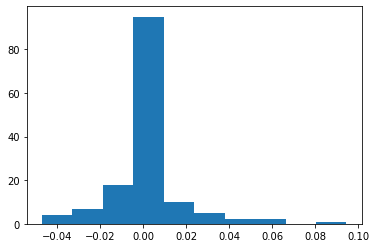

decoding on brain_area TT
found!
max diff:  0.043247126436781524


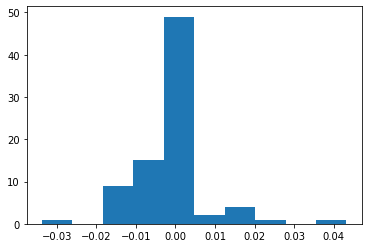

decoding on brain_area LD
decoding on brain_area SUB
decoding on brain_area VISp
decoding on brain_area VISa
decoding on brain_area LSr
decoding on brain_area MOs
found!
max diff:  0.06479885057471269


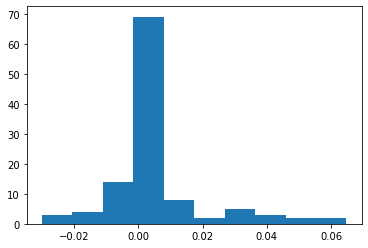

session 8
decoding on brain_area TH
decoding on brain_area ORBm
decoding on brain_area CA3
decoding on brain_area CA1
decoding on brain_area root
decoding on brain_area PL
decoding on brain_area VISl
decoding on brain_area TT
decoding on brain_area VISam
decoding on brain_area LD
decoding on brain_area LSr
decoding on brain_area VPL
session 9
decoding on brain_area SCm
found!
max diff:  0.04161953242835603


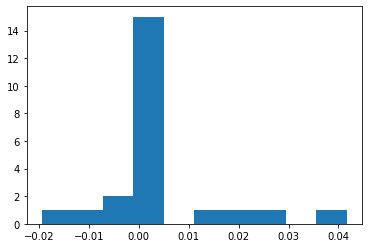

decoding on brain_area GPe
decoding on brain_area SCsg
decoding on brain_area DG
found!
max diff:  0.04652149321266963


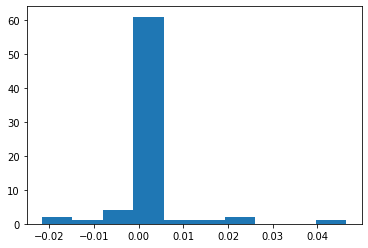

decoding on brain_area CA1
decoding on brain_area POL
decoding on brain_area root
decoding on brain_area VISrl
decoding on brain_area VISl
decoding on brain_area MRN
decoding on brain_area POST
decoding on brain_area VISp
decoding on brain_area MB
found!
max diff:  0.06330128205128216


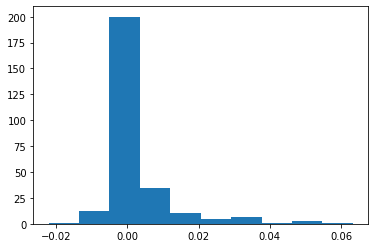

session 10
decoding on brain_area MOp
decoding on brain_area root
decoding on brain_area CP
decoding on brain_area LSc
decoding on brain_area LSr
decoding on brain_area PT
session 11
decoding on brain_area ACA
decoding on brain_area LGd
decoding on brain_area MD
decoding on brain_area DG
decoding on brain_area CA1
decoding on brain_area root
decoding on brain_area PL
decoding on brain_area LH
decoding on brain_area VISam
decoding on brain_area SUB
decoding on brain_area VISp
decoding on brain_area MOs
session 12
decoding on brain_area ACA
decoding on brain_area LGd
decoding on brain_area SCm
decoding on brain_area DG
decoding on brain_area CA1
decoding on brain_area SCs
decoding on brain_area MS
decoding on brain_area root
decoding on brain_area PL
decoding on brain_area RN
decoding on brain_area VISam
decoding on brain_area MRN
decoding on brain_area ZI
decoding on brain_area MB
decoding on brain_area MOs
session 13
decoding on brain_area SCm
decoding on brain_area CA1
decoding on bra

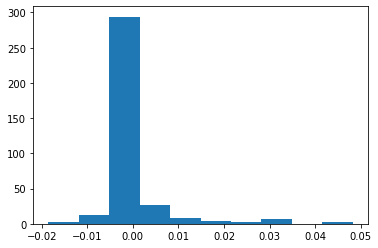

decoding on brain_area LD
decoding on brain_area VPM
session 17
decoding on brain_area TH
decoding on brain_area LGd
decoding on brain_area CA3
decoding on brain_area root
decoding on brain_area SNr
decoding on brain_area CP
decoding on brain_area SI
decoding on brain_area OT
decoding on brain_area ACB
decoding on brain_area ZI
session 18
decoding on brain_area LP
decoding on brain_area APN
found!
max diff:  0.04580026455026465


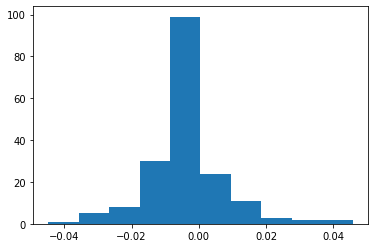

decoding on brain_area CA1
decoding on brain_area DG
found!
max diff:  0.06349206349206349


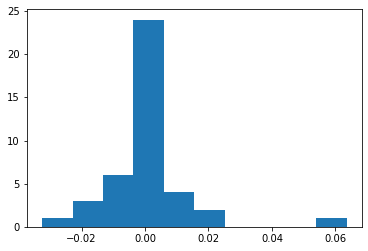

decoding on brain_area POL
decoding on brain_area root
found!
max diff:  0.07853835978835988


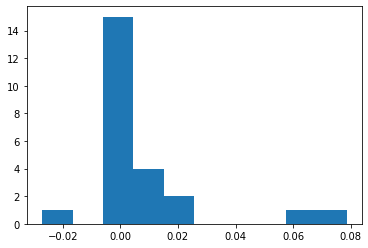

decoding on brain_area VISam
found!
max diff:  0.045634920634920584


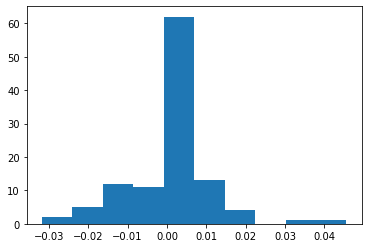

decoding on brain_area SUB
decoding on brain_area VISpm
found!
max diff:  0.04530423280423279


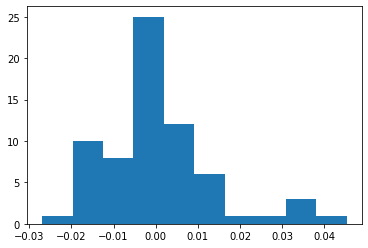

session 19
decoding on brain_area TH
decoding on brain_area LGd
found!
max diff:  0.042572463768115965


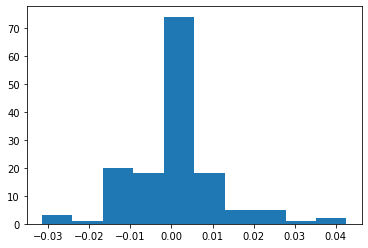

decoding on brain_area LP
decoding on brain_area CA1
decoding on brain_area DG
decoding on brain_area SPF
decoding on brain_area root
decoding on brain_area MG
found!
max diff:  0.05208333333333326


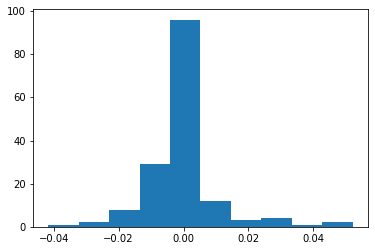

decoding on brain_area SUB
decoding on brain_area VISp
decoding on brain_area VISa
session 20
decoding on brain_area VAL
found!
max diff:  0.1339285714285714


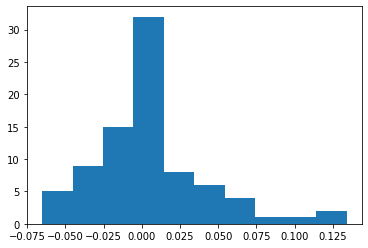

decoding on brain_area MOp
found!
max diff:  0.08241758241758235


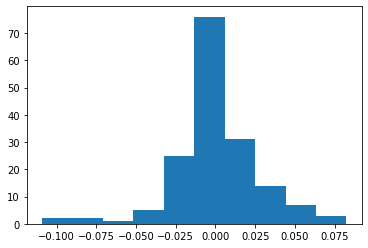

decoding on brain_area root
decoding on brain_area SSp
found!
max diff:  0.1778846153846153


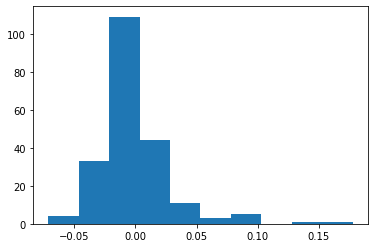

decoding on brain_area LD
found!
max diff:  0.125


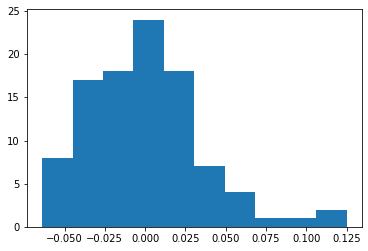

session 21
decoding on brain_area ACA
decoding on brain_area VISp
decoding on brain_area SCsg
decoding on brain_area RSP
decoding on brain_area PL
decoding on brain_area IC
decoding on brain_area TT
decoding on brain_area MRN
decoding on brain_area ACB
decoding on brain_area MOs
session 22
decoding on brain_area LP
decoding on brain_area PO
decoding on brain_area DG
decoding on brain_area CA1
found!
max diff:  0.04452614379084974


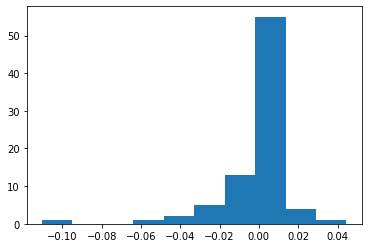

decoding on brain_area root
found!
max diff:  0.07352941176470584


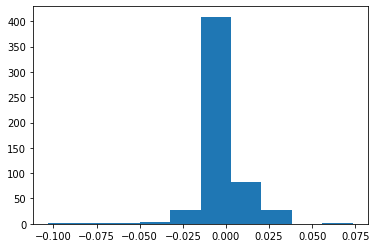

decoding on brain_area VISam
session 23
decoding on brain_area SCig
found!
max diff:  0.07683982683982682


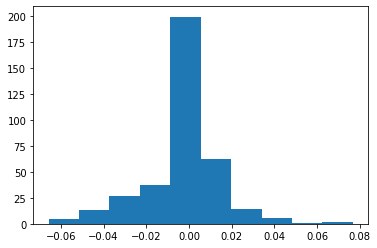

decoding on brain_area SCsg
found!
max diff:  0.052218614718614775


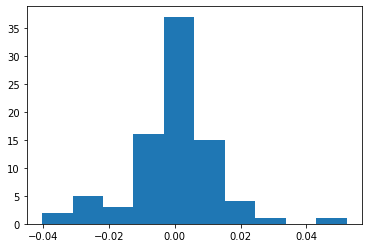

decoding on brain_area CA1
found!
max diff:  0.052489177489177474


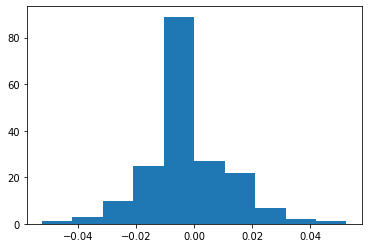

decoding on brain_area RSP
found!
max diff:  0.08116883116883122


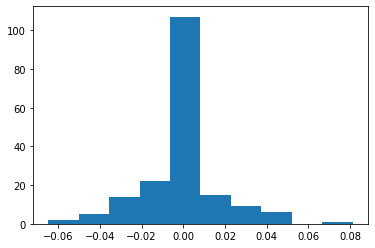

decoding on brain_area root
decoding on brain_area VISrl
decoding on brain_area MRN
found!
max diff:  0.07656926406926401


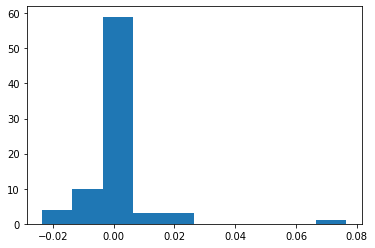

decoding on brain_area VISpm
found!
max diff:  0.0714285714285714


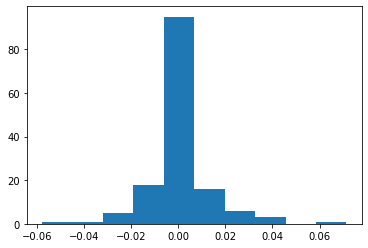

decoding on brain_area CA2
found!
max diff:  0.051948051948051965


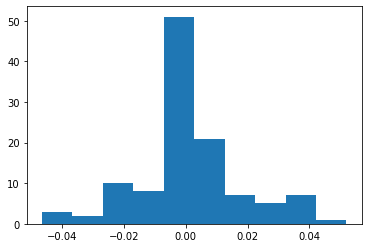

session 24
decoding on brain_area ILA
decoding on brain_area ACA
decoding on brain_area SCig
decoding on brain_area SCsg
decoding on brain_area RSP
decoding on brain_area root
decoding on brain_area PL
decoding on brain_area TT
decoding on brain_area MRN
decoding on brain_area VISp
decoding on brain_area DP
decoding on brain_area MOs
session 25
decoding on brain_area SCig
found!
max diff:  0.04345238095238102


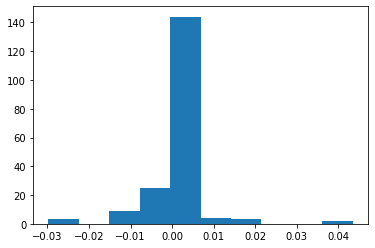

decoding on brain_area root
decoding on brain_area MRN
decoding on brain_area VISp
decoding on brain_area MOs
found!
max diff:  0.06755952380952379


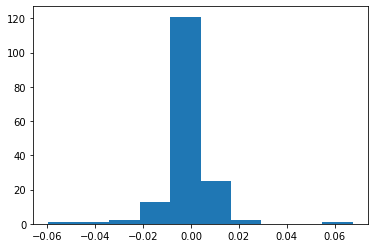

session 26
decoding on brain_area ACA
decoding on brain_area LP
decoding on brain_area PO
decoding on brain_area CA1
decoding on brain_area DG
decoding on brain_area root
decoding on brain_area PL
decoding on brain_area VISam
decoding on brain_area LD
decoding on brain_area ACB
decoding on brain_area MOs
session 27
decoding on brain_area SCig
found!
max diff:  0.05882352941176483


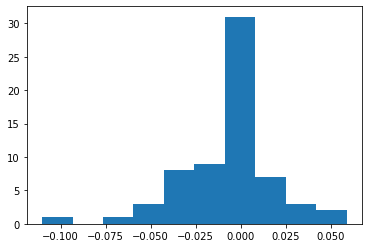

decoding on brain_area LP
decoding on brain_area SCsg
decoding on brain_area APN
found!
max diff:  0.05147058823529416


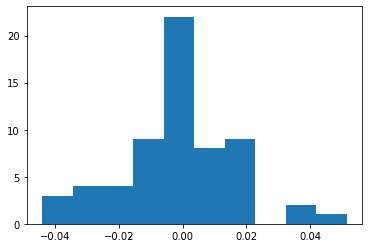

decoding on brain_area CA1
found!
max diff:  0.07352941176470584


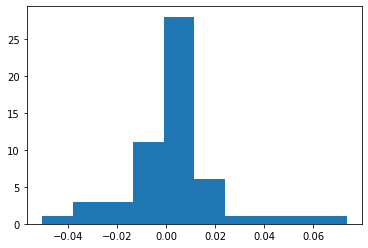

decoding on brain_area RSP
found!
max diff:  0.08864379084967322


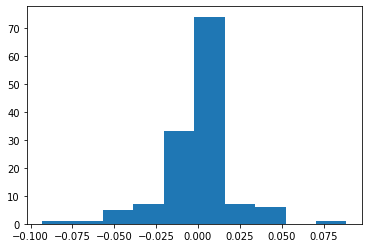

decoding on brain_area DG
decoding on brain_area root
decoding on brain_area POL
decoding on brain_area MRN
found!
max diff:  0.04370915032679734


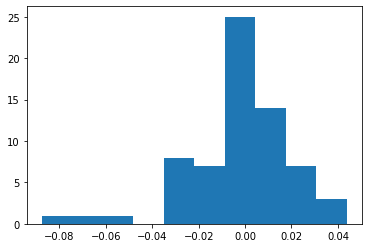

decoding on brain_area VISpm
found!
max diff:  0.05882352941176472


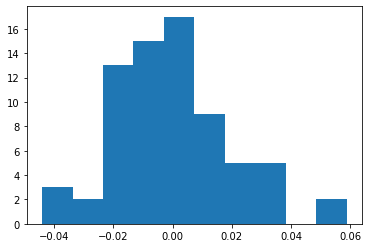

session 28
decoding on brain_area CP
found!
max diff:  0.0803571428571428


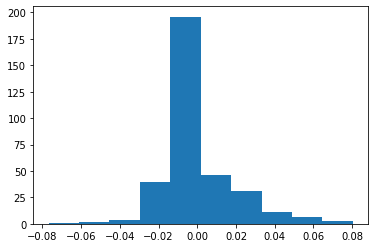

decoding on brain_area SSp
found!
max diff:  0.1428571428571428


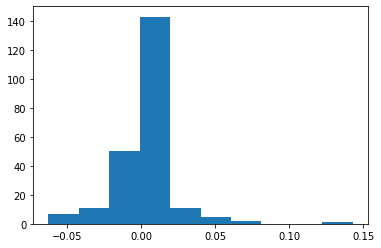

decoding on brain_area MOp
found!
max diff:  0.106547619047619


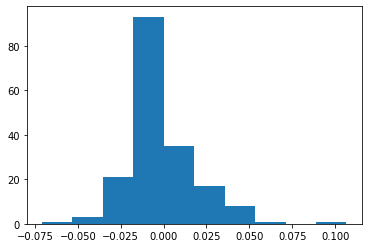

session 29
decoding on brain_area ACA
found!
max diff:  0.1328125


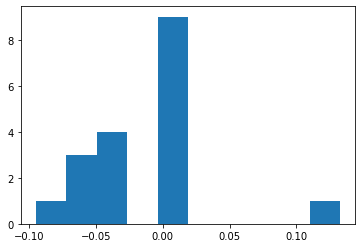

decoding on brain_area LP
found!
max diff:  0.1484375


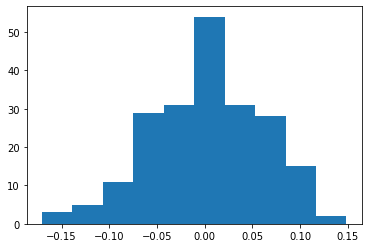

decoding on brain_area MD
found!
max diff:  0.1484375


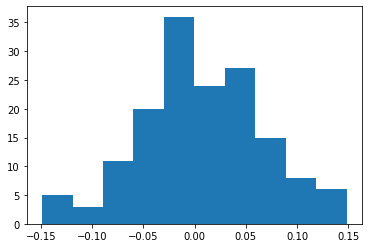

decoding on brain_area PO
found!
max diff:  0.17738970588235292


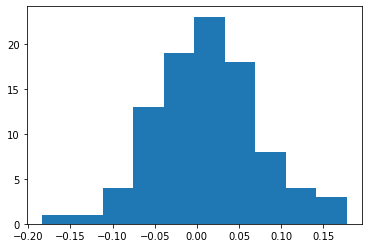

decoding on brain_area DG
found!
max diff:  0.13327205882352944


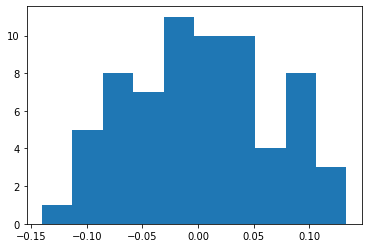

decoding on brain_area RSP
found!
max diff:  0.10294117647058826


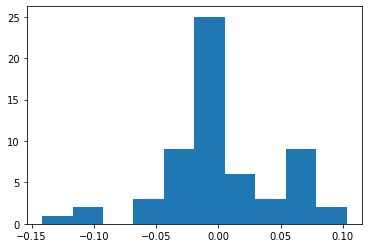

decoding on brain_area CA1
found!
max diff:  0.19255514705882348


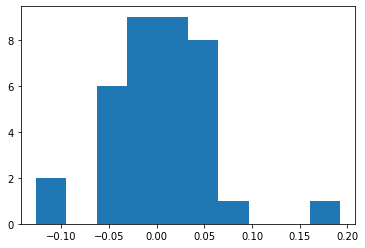

decoding on brain_area CL
found!
max diff:  0.1783088235294117


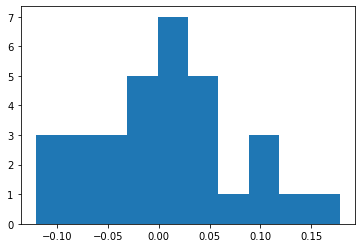

decoding on brain_area LS
found!
max diff:  0.18474264705882348


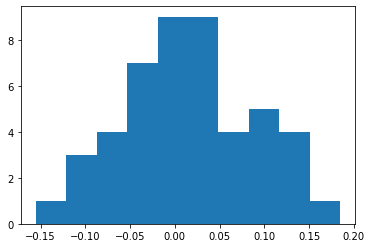

decoding on brain_area root
found!
max diff:  0.11259191176470595


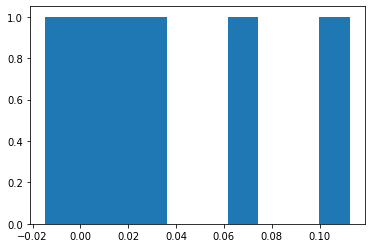

decoding on brain_area SUB
found!
max diff:  0.14797794117647067


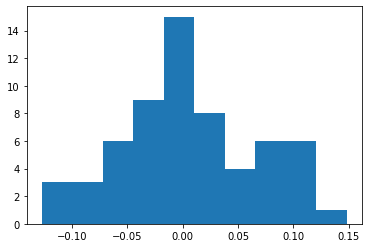

decoding on brain_area VISa
found!
max diff:  0.04549632352941174


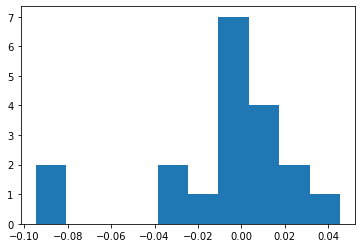

decoding on brain_area MOs
found!
max diff:  0.17876838235294112


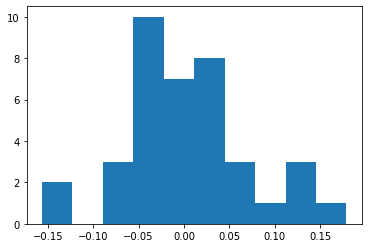

decoding on brain_area VPM
found!
max diff:  0.20726102941176472


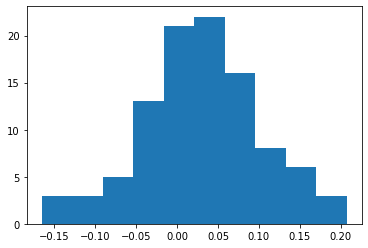

session 30
decoding on brain_area TH
decoding on brain_area SCm
decoding on brain_area CA3
decoding on brain_area OLF
found!
max diff:  0.04646164021164034


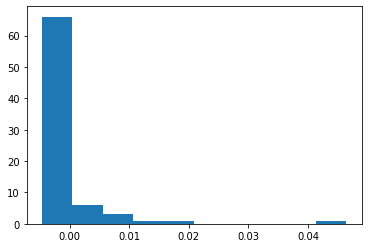

decoding on brain_area SNr
found!
max diff:  0.04166666666666674


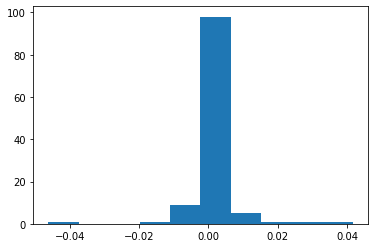

decoding on brain_area POST
decoding on brain_area ORB
decoding on brain_area MOs
found!
max diff:  0.04613095238095244


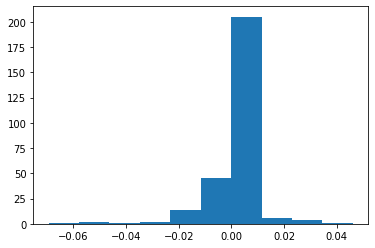

session 31
decoding on brain_area SCm
decoding on brain_area RSP
decoding on brain_area SCs
decoding on brain_area OLF
decoding on brain_area PAG
decoding on brain_area root
decoding on brain_area MRN
decoding on brain_area ORB
decoding on brain_area MOs
session 32
decoding on brain_area LGd
found!
max diff:  0.0439723320158103


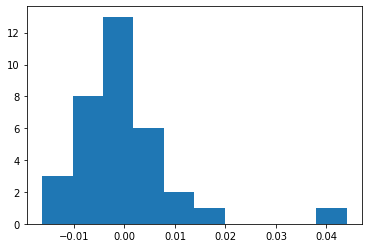

decoding on brain_area CA3
decoding on brain_area CA1
decoding on brain_area root
decoding on brain_area SNr
decoding on brain_area CP
found!
max diff:  0.060523715415019885


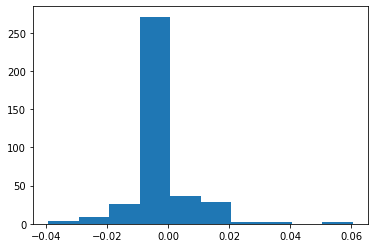

decoding on brain_area ZI
decoding on brain_area VPM
decoding on brain_area EP
session 33
decoding on brain_area BMA
decoding on brain_area RT
found!
max diff:  0.053373015873015905


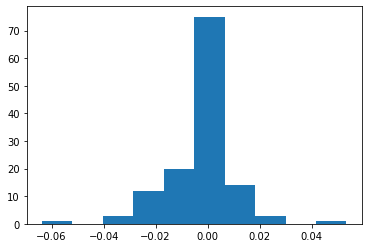

decoding on brain_area LP
decoding on brain_area PO
decoding on brain_area root
decoding on brain_area COA
decoding on brain_area MB
session 34
decoding on brain_area ACA
decoding on brain_area TH
decoding on brain_area LGd
decoding on brain_area LP
decoding on brain_area MD
decoding on brain_area LS
decoding on brain_area CA1
decoding on brain_area RSP
decoding on brain_area DG
decoding on brain_area root
decoding on brain_area LH
decoding on brain_area VISam
decoding on brain_area MOs
session 35
decoding on brain_area SCm
decoding on brain_area SCsg
decoding on brain_area root
decoding on brain_area PL
decoding on brain_area VISam
decoding on brain_area MRN
decoding on brain_area CA
found!
max diff:  0.04727011494252875


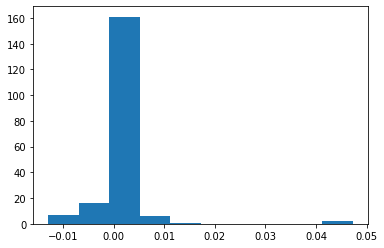

decoding on brain_area MOs
session 36
decoding on brain_area SCm
decoding on brain_area RSP
decoding on brain_area SCs
decoding on brain_area MB
found!
max diff:  0.05476190476190479


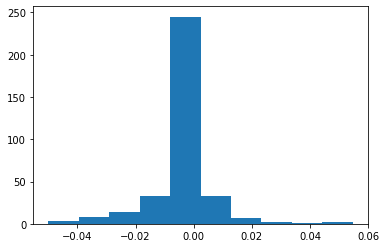

decoding on brain_area root
decoding on brain_area VISam
found!
max diff:  0.04285714285714293


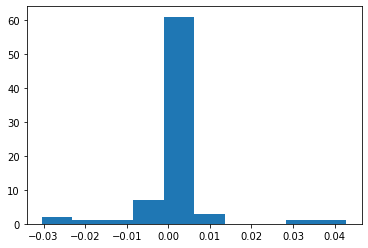

decoding on brain_area ORB
decoding on brain_area PAG
decoding on brain_area MOs
session 37
decoding on brain_area LGd
decoding on brain_area GPe
decoding on brain_area CA3
decoding on brain_area BLA
found!
max diff:  0.046875


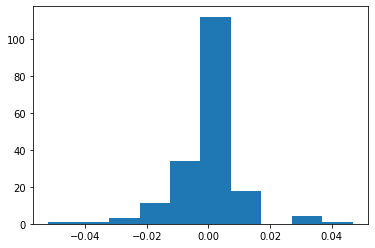

decoding on brain_area root
decoding on brain_area SNr
session 38
decoding on brain_area ILA
decoding on brain_area ACA
decoding on brain_area LP
decoding on brain_area DG
decoding on brain_area CA1
decoding on brain_area root
decoding on brain_area PL
decoding on brain_area VISam
decoding on brain_area SUB
decoding on brain_area VISp
decoding on brain_area MOs


In [72]:
window = slice(0, 50, 1)
# window = slice(30, 50, 1)
thresh_print = 0.04
for i_session in range(n_sessions):
  print("session", i_session)
  filtered_data_focus = filtered_data[i_session]
  outcomes_correct = get_outcomes_correct_with_session(filtered_data_focus)
  brain_areas = set(filtered_data_focus['brain_area'])
  for brain_area in brain_areas:
    print("decoding on brain_area", brain_area)
    spikes_per_neuron = get_neurons_spikes_with_session_area_window(filtered_data_focus, brain_area, window)
    decoding_accuracies, decoding_accuracies_chance = compute_single_neuron_decoding_accuracies(spikes_per_neuron, outcomes_correct)
    decoding_accuracies_diff = decoding_accuracies - decoding_accuracies_chance
    if np.any(decoding_accuracies_diff > thresh_print):
      print("found!")
      # print("decoding_accuracies", decoding_accuracies)
      # print("decoding_accuracies_chance", decoding_accuracies_chance)
      print("max diff: ", (decoding_accuracies_diff).max())
      plt.figure()
      plt.hist(decoding_accuracies_diff)
      plt.show()

## Fitting the model manually

In [66]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.
  
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.  
  """


  y_pred = model.predict(X)

  accuracy = np.count_nonzero(y_pred==y)/len(y)

  return accuracy

avg_spikes=spikes_focus.mean(axis=0)
print(avg_spikes.shape)
# outcomes_correct=>label 0 or 1
y = outcomes_correct
X = avg_spikes

# First define the model
log_reg = LogisticRegression(penalty="none")
#Then fit it to data
log_reg.fit(X, y)
y_pred = log_reg.predict(X)

train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data averaging over all neurons considering the whole time period: {train_accuracy:.2%}")

(414, 250)
Accuracy on the training data: 100.00%


In [69]:
X = avg_spikes[:, 0:50]
log_reg = LogisticRegression(penalty="none")
log_reg.fit(X, y)
y_pred = log_reg.predict(X)

train_accuracy = compute_accuracy(X, y, log_reg)

print(f"Accuracy on the training data averaging over all neurons considering the prestimulus period: {train_accuracy:.2%}")

Accuracy on the training data averaging over all neurons considering the prestimulus period: 68.12%


In [71]:
# X = spikes_focus[24, :, 0:50]
# log_reg = LogisticRegression(penalty="none")
# log_reg.fit(X, y)
# y_pred = log_reg.predict(X)

# train_accuracy = compute_accuracy(X, y, log_reg)

# print(f"Accuracy on the training data with a single neuron considering the prestimulus period: {train_accuracy:.2%}")

## Decode on average over the neurons and the prestimulus time zone

In [28]:
avg_neurones_prestimulus=spikes_focus[:,:,:50].mean(axis=2)
y = outcomes_correct
X = avg_neurones_prestimulus.T
scores = cross_val_score(LogisticRegression(penalty='l2'), X, y, cv=8) # k=8 crossvalidation
scores.mean()

0.6550716440422323

In [29]:
X_random=avg_neurones_prestimulus.T.copy()
np.random.shuffle(X_random)
chance_decoding_accuracy = cross_val_score(LogisticRegression(penalty='l2'),X_random, y, cv=8).mean() # k=8 crossvalidation
chance_decoding_accuracy

0.6256127450980392

In [22]:
print("X.shape", X.shape)

X.shape (414, 275)


[0.65973793 0.64503205 0.63772624 0.63772624 0.63772624 0.62570701
 0.68410633 0.63772624 0.63772624 0.63772624 0.63772624 0.63772624
 0.6353224  0.63772624 0.63772624 0.62811086 0.63772624 0.63772624
 0.63772624 0.63772624 0.63772624 0.63777338 0.64258107 0.63772624
 0.63772624 0.63772624 0.64272247 0.67449095 0.63772624 0.64503205
 0.63772624 0.63772624 0.63772624 0.6353224  0.63772624 0.63772624
 0.63772624 0.64008296 0.63772624 0.64258107 0.64262821 0.63291855
 0.63772624 0.63772624 0.62575415 0.63772624 0.63772624 0.63772624
 0.64017722 0.63772624 0.63772624 0.6353224  0.63772624 0.63772624
 0.63772624 0.64498492 0.63772624 0.63772624 0.63772624 0.6353224
 0.6353224  0.65224359 0.6353224  0.63772624 0.63772624 0.6353224
 0.63772624 0.66223605 0.63772624 0.63772624 0.6424868  0.63772624
 0.63772624 0.62811086 0.63772624 0.6353224  0.63772624 0.6353224
 0.64258107 0.64022436 0.63772624 0.63772624 0.63772624 0.63051471
 0.63527526 0.63772624 0.63772624 0.63772624 0.63027903 0.6525264

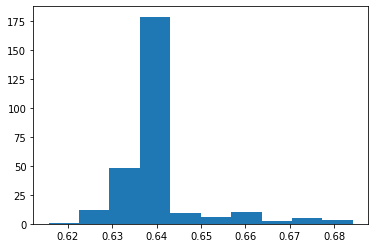

In [31]:
# Iterate over single neurons
n_neurons = avg_neurones_prestimulus.shape[0]
mean_decoding_accuracies = np.empty(n_neurons)
for i_neuron in range(n_neurons):
  X = avg_neurones_prestimulus[i_neuron, :][:, None]
  mean_decoding_accuracies[i_neuron] = cross_val_score(LogisticRegression(penalty='none'), X, y, cv=8).mean()
plt.hist(mean_decoding_accuracies)
print(mean_decoding_accuracies)
print(mean_decoding_accuracies.max())

## Decode from all the neurons, averaged over the prestimulus time zone

In [24]:
#(275, 414, 250) =>(414,275*250)
X_all=[]

y = outcomes_correct

for i in range(len(spikes_focus[:,:,:50][0])):
  all_neuron_over_time_by_trial=[]
  for j in range(len(spikes_focus[:,:,:50])):
    
    for k in spikes_focus[:,:,:50][j][i]:
      all_neuron_over_time_by_trial.append(k)
  X_all.append(all_neuron_over_time_by_trial)

X_all=np.array(X_all)
X_all.shape

(414, 13750)

In [25]:
cross_val_score(LogisticRegression(penalty='l2'), X_all, y, cv=8) # k=8 crossvalidation

array([0.59615385, 0.65384615, 0.59615385, 0.63461538, 0.65384615,
       0.61538462, 0.78431373, 0.66666667])

# look for active neurons

In [13]:
count=0
active_trial=np.zeros(len(spikes_focus))
for i in range(len(spikes_focus)):
  count=0
  for j in range(len(spikes_focus[0,:,0])):
    if spikes_focus[i,j,:].sum()<5:
      count+=1
  active_trial[i]=len(spikes_focus[0,:,0])-count
  #print(count,'/',j+1)
print(np.count_nonzero(active_trial>20))

169


In [ ]:
#@title Show some spikes data
_=plt.eventplot(spikes_focus[20:30,2,:])
spikes_focus[25:26,2,:]